In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
cuda = torch.cuda.is_available()
import numpy as np
import collections
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from skimage import io
from torchvision import models
import csv
import tripletloss
import torchvision
from PIL import Image

In [2]:

#981
train_size= 589
val_size= 196
test_size = 196


class Config:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

config = Config(
    center_loss = False,
    triplet_loss = True,
    num_classes = 11,
    feat_dim = 11,
    lr_cent = 0.5,
    closs_weight = 0.5,
    margin = 0
)

In [3]:
train_data_map = {}

In [4]:
val_data_map = {}

In [5]:
with open("training.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    for row in reader:
        train_data_map[row[0]] = row[6]

FileNotFoundError: [Errno 2] No such file or directory: 'training.csv'

In [25]:
with open("validation.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    for row in reader:
        val_data_map[row[0]] = row[6]

FileNotFoundError: [Errno 2] No such file or directory: 'validation.csv'

In [6]:
def parse_data(datadir, train_data_map, val_data_map):
    train_img_list = []
    val_img_list = []
    extensions = ["BMP", "JPEG", "JPG", "Jpeg", "PNG", "bmp", "jpeg", "jpg", "png", "tif"]
    for root, directories, filenames in os.walk(datadir): 
        for filename in filenames:
            extenstion = filename.split(".")[-1]
            if extenstion in extensions:  
                
                filei = os.path.join(root, filename)
                split_filename = filei.split("/")
                filename = split_filename[-2] + "/" + split_filename[-1]
                if filename in train_data_map:
                    train_img_list.append(filei)
                elif filename in val_data_map:
                    val_img_list.append(filei)
               
    return train_img_list, val_img_list

In [7]:
train_img_list, val_img_list = parse_data("Manually_Annotated_Images", train_data_map, val_data_map)

In [8]:
train_img_list = train_img_list[:10]
len(train_img_list)


0

In [9]:
len(val_img_list)

0

In [10]:
class ImageDataset(Dataset):
    def __init__(self, img_list, data_map):
        self.img_list = img_list
        self.data_map = data_map
        
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        
        img_file = self.img_list[index]
        img = Image.open(img_file)
        img_h = 224
        img_w = 224
        img = torchvision.transforms.Resize((img_h,img_w))(img)
        img = torchvision.transforms.ToTensor()(img)
        split_filename = img_file.split("/")
        filename = split_filename[-2] + "/" + split_filename[-1]
        
        label = self.data_map[filename]
        return img, int(label)

In [11]:
train_data = ImageDataset(train_img_list, train_data_map)

In [12]:
len(train_data)

0

In [13]:
train_data_len = int(np.floor(0.8 * len(train_data)))
val_data_len = len(train_data) - train_data_len
train_dataset, val_dataset = torch.utils.data.random_split(train_data, (train_data_len, val_data_len))

In [14]:
# for file_name in train_data_map:
#     labels.add(train_data_map[file_name])

In [15]:
val_data = ImageDataset(val_img_list, val_data_map)

In [16]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

ValueError: num_samples should be a positive integeral value, but got num_samples=0

In [17]:
import logging
logging.basicConfig(filename="training_baseline_affectnet_part_8.log" ,
                            filemode="a+")
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [18]:
class ConvBlock(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
                          nn.Conv2d(in_channels=C_in, out_channels=C_out, kernel_size=kernel_size, stride=stride),
                          nn.ReLU(),
                          nn.MaxPool2d(2))
        
    def forward(self, x):
        return self.block(x)
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class BaselineModel(nn.Module):
    def __init__(self, num_blocks):
        super(BaselineModel, self).__init__()
        layers = []
        num_classes = 11
        channels = [3, 64, 128, 256] # this needs to be modified according to num_blocks
        
        for i in range(num_blocks):
            layers.append(ConvBlock(C_in=channels[i], C_out=channels[i+1], kernel_size=5, stride=1))
        
        layers.append(nn.Dropout(p=0.25))
        
        layers.append(Flatten())
        
        layers.append(nn.Linear(256*24*24, 512))
        
        layers.append(nn.Dropout(p=0.5))
        
        layers.append(nn.Linear(512, num_classes))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [19]:
device = torch.device("cuda" if cuda else "cpu")
model = BaselineModel(num_blocks=3)

criterion_tripletloss = tripletloss.TripletLoss(config.margin)

optimizer = optim.Adam(model.parameters())
optimizer_tripletloss = torch.optim.Adam(criterion_tripletloss.parameters(), lr=config.lr_cent)

print(model)

ValueError: optimizer got an empty parameter list

In [20]:
def train(model,n_epochs,train_dataloader, test_loader):
    model.train()
    model.to(device)
    train_losses = []
    eval_losses = []
    eval_accs = []
    for epoch in range(n_epochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_dataloader):
            feats, labels = feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(feats)
            loss = criterion(outputs, labels.long())
            loss.backward()
            
            optimizer.step()
            
            avg_loss += loss.item()
            if batch_num % 50 == 49:
                logger.info('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
 
                avg_loss = 0.0    
        
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        train_loss, train_accuracy = test_classify_loss(model,train_dataloader)
        test_loss, test_accuracy = test_classify_loss(model,test_loader)
        eval_losses.append(test_loss)
        train_losses.append(train_loss)
        eval_accs.append(test_accuracy)
        logger.info('Epoch: {}\tTrain Loss: {}\tTrain Acc: {}\tTest-Loss: {}\tTest-acc: {:.4f}'.format(epoch+1, train_loss,train_accuracy, test_loss, test_accuracy))
    return train_losses, eval_losses, eval_accs

def test_classify_loss(model, test_loader):
    with torch.no_grad():
        model.eval()
        test_loss = []
        accuracies = 0
        total = 0
        for batch_num, (feats, labels) in enumerate(test_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            loss = criterion(outputs, labels.long())
            accuracies += float(torch.sum(torch.eq(pred_labels, labels)).item())
            total+=float(len(labels))
            test_loss.extend([loss.item()]*feats.size()[0])
            torch.cuda.empty_cache()
            del feats
            del labels
    model.train()
    return np.mean(test_loss), accuracies/total

In [21]:
def train_closs(model,n_epochs,train_dataloader, test_loader):
    model.train()
    model.to(device)
    train_losses = []
    eval_losses = []
    eval_accs = []
    for epoch in range(n_epochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_dataloader):
            feats, labels = feats.to(device), labels.to(device)
            
            optimizer.zero_grad()
            optimizer_closs.zero_grad()
            
            outputs = model(feats)
            
            loss = criterion(outputs, labels.long())
            c_loss = criterion_closs(outputs, labels.long())
            loss = loss + config.closs_weight * c_loss
            loss.backward()
            
            optimizer.step()
            for param in criterion_closs.parameters():
                param.grad.data *= (1. / config.closs_weight)
            optimizer_closs.step()
            
            avg_loss += loss.item()
            if batch_num % 50 == 49:
                logger.info('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
 
                avg_loss = 0.0    
        
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        train_loss, train_accuracy = test_classify_closs(model,train_dataloader)
        test_loss, test_accuracy = test_classify_closs(model,test_loader)
        eval_losses.append(test_loss)
        train_losses.append(train_loss)
        eval_accs.append(test_accuracy)
        logger.info('Epoch: {}\tTrain Loss: {}\tTrain Acc: {}\tTest-Loss: {}\tTest-acc: {:.4f}'.format(epoch+1, train_loss,train_accuracy, test_loss, test_accuracy))
    return train_losses, eval_losses, eval_accs

def test_classify_closs(model, test_loader):
    with torch.no_grad():
        model.eval()
        test_loss = []
        accuracies = 0
        total = 0
        for batch_num, (feats, labels) in enumerate(test_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            loss = criterion(outputs, labels.long())
            c_loss = criterion_closs(outputs, labels.long())
            loss = loss + config.closs_weight * c_loss
            
            accuracies += float(torch.sum(torch.eq(pred_labels, labels)).item())
            total+=float(len(labels))
            test_loss.extend([loss.item()]*feats.size()[0])
            torch.cuda.empty_cache()
            del feats
            del labels
    model.train()
    return np.mean(test_loss), accuracies/total

In [22]:
def train_tripletloss(model,n_epochs,train_dataloader, test_loader):
    model.train()
    model.to(device)
    train_losses = []
    eval_losses = []
    eval_accs = []
    for epoch in range(n_epochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_dataloader):
            feats, labels = feats.to(device), labels.to(device)
            
#             optimizer.zero_grad()
#             optimizer_closs.zero_grad()
            
            outputs = model(feats)
            
            t_loss = criterion_tripletloss(outputs, labels.long())
            loss = t_loss
            loss.backward()
            
            optimizer_tripletloss.step()
            
            avg_loss += loss.item()
            if batch_num % 50 == 49:
                logger.info('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
 
                avg_loss = 0.0    
        
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        train_loss, train_accuracy = test_classify_tripletloss(model,train_dataloader)
        test_loss, test_accuracy = test_classify_tripletloss(model,test_loader)
        eval_losses.append(test_loss)
        train_losses.append(train_loss)
        eval_accs.append(test_accuracy)
        logger.info('Epoch: {}\tTrain Loss: {}\tTrain Acc: {}\tTest-Loss: {}\tTest-acc: {:.4f}'.format(epoch+1, train_loss,train_accuracy, test_loss, test_accuracy))
    return train_losses, eval_losses, eval_accs

def test_classify_tripletloss(model, test_loader):
    with torch.no_grad():
        model.eval()
        test_loss = []
        accuracies = 0
        total = 0
        for batch_num, (feats, labels) in enumerate(test_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            t_loss = criterion_tripletloss(outputs, labels.long())
            loss = t_loss
            
            accuracies += float(torch.sum(torch.eq(pred_labels, labels)).item())
            total+=float(len(labels))
            test_loss.extend([loss.item()]*feats.size()[0])
            torch.cuda.empty_cache()
            del feats
            del labels
    model.train()
    return np.mean(test_loss), accuracies/total

In [23]:
train_losses, eval_losses, eval_accs = train_tripletloss(model,5, train_dataloader, val_dataloader)

NameError: name 'train_dataloader' is not defined

NameError: name 'train_losses' is not defined

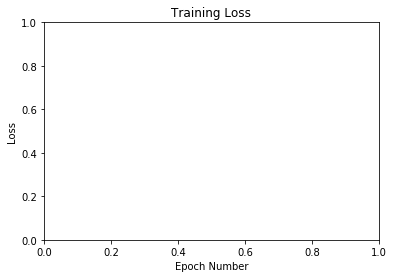

In [24]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.savefig("training_loss.png")

In [25]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('accuracy')
plt.plot(eval_accs)
plt.savefig("val_acc.png")

In [26]:
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, 
                                               shuffle=False, num_workers=8)

NameError: name 'test_dataset' is not defined

In [ ]:
test_loss, test_accuracy = test_classify_closs(model, test_data_loader)

In [ ]:
test_loss, test_accuracy